# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [334]:
# pip install lightgbm

In [335]:
#pip install catboost

In [336]:
#pip install phik

In [337]:
import pandas as pd
pd.options.mode.chained_assignment = None
import os
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder 
from sklearn.preprocessing import StandardScaler 
import phik

import scipy.sparse

In [338]:
if os.path.exists('/datasets/autos.csv'):
    df = pd.read_csv('/datasets/autos.csv')
else:
    df = pd.read_csv('autos.csv')

df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Переименуем колонки.

In [340]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

C:\Users\Вера\AppData\Local\Temp\ipykernel_20880\863562265.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]


In [341]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Оценим распределение значений признаков.

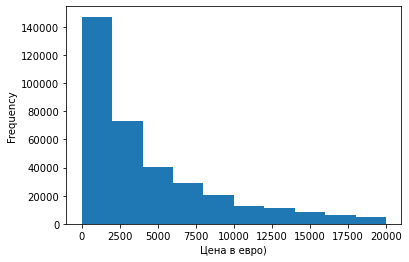

In [342]:
df['price'].plot(kind='hist').set_xlabel('Цена в евро)');

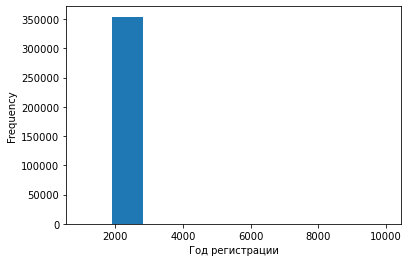

In [343]:
df['registration_year'].plot(kind='hist').set_xlabel('Год регистрации');

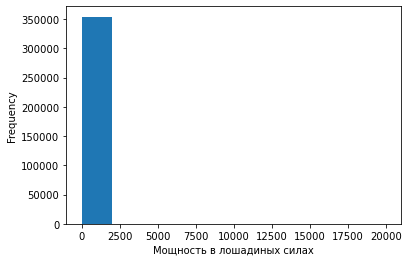

In [344]:
df['power'].plot(kind='hist').set_xlabel('Мощность в лошадиных силах');

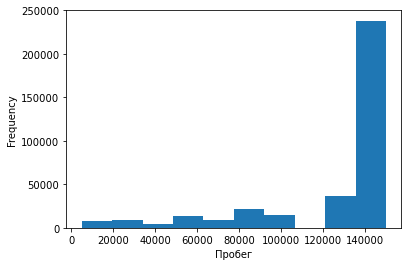

In [345]:
df['kilometer'].plot(kind='hist').set_xlabel('Пробег');

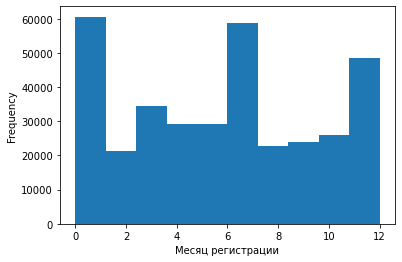

In [346]:
df['registration_month'].plot(kind='hist').set_xlabel('Месяц регистрации');

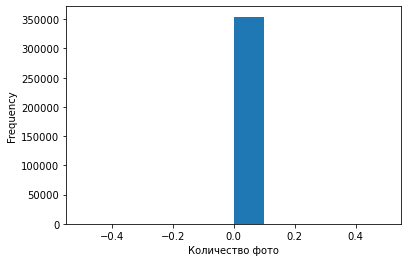

In [347]:
df['number_of_pictures'].plot(kind='hist').set_xlabel('Количество фото');

In [348]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
number_of_pictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postal_code,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


Судя по первичному обзору в данных присутствуют некорректные значения:
* много строк с ценой 0
* слишком большие и слишком маленькие значения в столбцах с мощностью и годом регистрации
* все значения в столбце с количеством фотографий пустые
* есть пропуски в данных
* больше всего автомобилей регистрируются в январе, июле и декабре
* в основном представлены машины с большим пробегом, медианное значение - 150 тыс км

Посчитаем строки с некорректным годом регистрации.

In [349]:
df.query('registration_year > 2016 or registration_year < 1980')['registration_year'].count()

17982

Удалим их, 5% строк несущественны.

In [350]:
df = df.query('1980 < registration_year < 2016')

Столбцы с количеством фотографий автомобиля, а также с почтовым кодом бесполезны, также удалим их.

In [351]:
df = df.drop(['number_of_pictures', 'postal_code'], axis=1)

Месяц регистрации автомобиля не имеет большого значения, важнее год. Удалим месяц регистрации.

In [352]:
df = df.drop(['registration_month'], axis=1)

Столбцы с датой скачивания анкеты из базы и датой создания анкеты практически одинаковы. Дата скачивания содержит время. Для модели эти данные излишни.

In [353]:
df = df.drop(['date_crawled'], axis=1)

Посчитаем процент строк с ценой меньше 100 евро от общего количества строк.

In [354]:
round(df.query('price < 100')['price'].count()/df['price'].count()*100, 0)

3.0

Удалим строки с ценой менее 100 евро, их не так много.

In [355]:
df = df.query('price > 100')

Проанализируем количество строк с неправдоподобно большими значениями в столбце с лошадиными силами.

In [356]:
round(df.query('power > 500')['power'].count()/df['power'].count()*100, 2)

0.11

Таких строк очень мало, удаляем.

In [357]:
df = df.query('power < 500')

In [358]:
round(df.query('power == 0').shape[0]/df.shape[0] * 100, 2)

8.83

Строк с нулевой мощностью 8.83% достаточно много, восстановить значение мощности можно было бы по модели. Но в этом столбце были пропущенные значения.

In [359]:
round(df['model'].isna().sum()/df.shape[0] * 100, 2)

4.15

Таких строк около 4% удалим их. Восстановить их корректно невозможно.

In [360]:
df = df.query('model == model')

Посмотрим, как распределены значения мощности до 100 л.с.

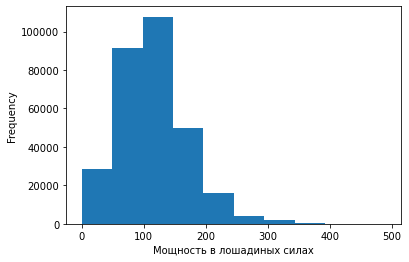

In [361]:
df['power'].plot(kind='hist').set_xlabel('Мощность в лошадиных силах');

Есть много околонулевых значений и немного значений до 40 л.с., которые скорее всего тоже являются ошибочными. Заменим их на медианные значения по модели.

In [362]:
df.loc[(df['power'] <= 40), 'power'] = None
df['power'] = df['power'].fillna(df.groupby('model')['power'].transform('median'))

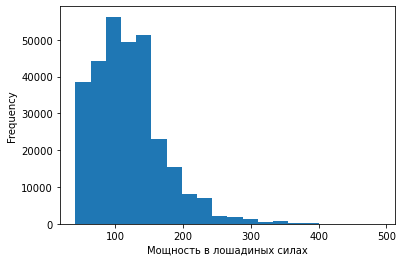

In [363]:
df['power'].plot(kind='hist', bins=20).set_xlabel('Мощность в лошадиных силах');

После обработки видно, что больше всего автомобилей с мощностью около 100 л.с., чаще всего мощность в пределах 90-150 л.с.

Проверим явные дубли и удалим их, если они есть.

In [364]:
df.duplicated().sum()

107

In [365]:
df = df.drop_duplicates()

Посмотрим на заполнение колонок с нечисловыми значениями: тип автомобильного кузова, тип коробки передач, тип топлива, марка и модель автомобиля.

In [366]:
df['vehicle_type'].unique()

array([nan, 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'coupe', 'other'], dtype=object)

Неявных дублей нет, часть значений заполнена other.

In [367]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Неявных дублей нет.

In [368]:
df['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Неявных дублей нет, часть значений заполнена other.

In [369]:
df['brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo'],
      dtype=object)

Неявных дублей нет.

In [370]:
df['model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Неявных дублей нет, часть значений заполнена значением other.

Вычислим разницу дат между датой создания анкеты и последним просмотром.

In [371]:
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d')
df['date_diff'] = (df['last_seen'] - df['date_created']).dt.days

In [372]:
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created,last_seen,date_diff
0,480,NaN,1993,manual,101.0,golf,150000,petrol,volkswagen,NaN,2016-03-24,2016-04-07 03:16:57,14
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,NaN,2016-03-14,2016-04-05 12:47:46,22
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,2016-03-17,2016-03-17 17:40:17,0
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,2016-03-31,2016-04-06 10:17:21,6
5,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes,2016-04-04,2016-04-06 19:17:07,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225.0,leon,150000,petrol,seat,yes,2016-03-19,2016-03-19 20:44:43,0
354363,1150,bus,2000,manual,125.0,zafira,150000,petrol,opel,no,2016-03-27,2016-03-29 10:17:23,2
354366,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no,2016-03-05,2016-03-11 18:17:12,6
354367,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no,2016-03-19,2016-04-07 07:15:26,19


Удалим столбцы с датами.

In [373]:
df = df.drop(['date_created', 'last_seen'], axis=1)

Оценим распределение времени между первой публикацей объявления и последним просмотром.

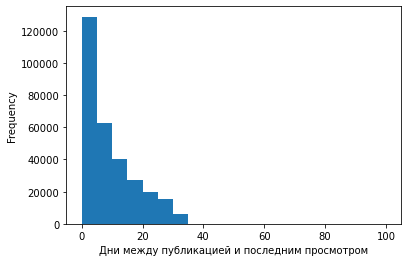

In [374]:
df['date_diff'].plot(kind='hist', bins=20, range=(0,100)).set_xlabel('Дни между публикацией и последним просмотром');

Большая часть публикаций через несколько дней после просмотра либо продается, либо не попадает в фильтры, т.к. разница между публикацией и последним просмотром всего несколько дней. Но есть и небольшое количество объявлений, которые продавались медленно.

Выведем количество пропущенных значений для каждого столбца.

In [375]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,2.000000
registration_year,0.000000
gearbox,4.000000
power,0.000000
model,0.000000
kilometer,0.000000
fuel_type,5.000000
brand,0.000000
repaired,16.000000


Осталось много пропущенных значений в столбцах с типом автомобильного кузова, признаком была ли машина в ремонте или нет, типом топлива и типом коробки передач. Тип кузова, топлива и коробки передач можно восстановить по модели. Медиану по категориальному признаку не возьмешь, используем наиболее частое значение.

In [376]:
df['vehicle_type'] = df['vehicle_type'].fillna(df.groupby('model')['vehicle_type']
                                               .transform(lambda x: x.value_counts().idxmax()))

In [377]:
df['gearbox'] = df['gearbox'].fillna(df.groupby('model')['gearbox']
                                                  .transform(lambda x: x.value_counts().idxmax()))  

In [378]:
df['fuel_type'] = df['fuel_type'].fillna(df.groupby('model')['fuel_type']
                                                  .transform(lambda x: x.value_counts().idxmax()))  

В признаке repaired 17% пропущенных значений. Заполним их 'other'.

In [379]:
df['repaired'] = df['repaired'].fillna('other')

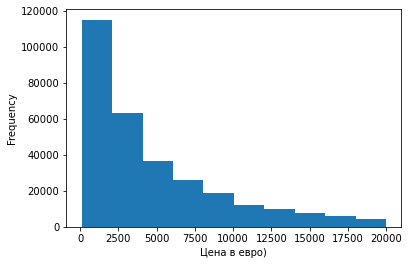

In [380]:
df['price'].plot(kind='hist').set_xlabel('Цена в евро)');

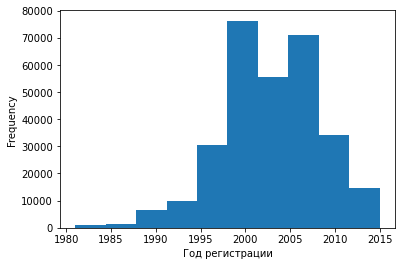

In [381]:
df['registration_year'].plot(kind='hist').set_xlabel('Год регистрации');

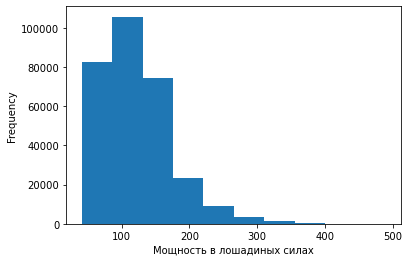

In [382]:
df['power'].plot(kind='hist').set_xlabel('Мощность в лошадиных силах');

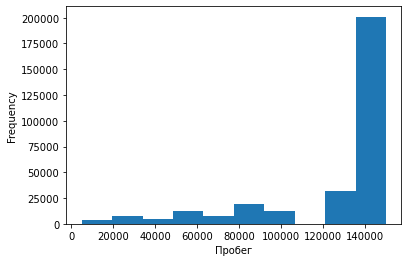

In [383]:
df['kilometer'].plot(kind='hist').set_xlabel('Пробег');

In [384]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300552 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              300552 non-null  int64  
 1   vehicle_type       300552 non-null  object 
 2   registration_year  300552 non-null  int64  
 3   gearbox            300552 non-null  object 
 4   power              300552 non-null  float64
 5   model              300552 non-null  object 
 6   kilometer          300552 non-null  int64  
 7   fuel_type          300552 non-null  object 
 8   brand              300552 non-null  object 
 9   repaired           300552 non-null  object 
 10  date_diff          300552 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 27.5+ MB


Проверим, коррелируют ли признаки между собой. Сильная корреляция независимых признаков (мультиколлениарность) может стать причиной переобучения линейных моделей.

In [385]:
#df.corr()

In [386]:
df.phik_matrix()

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer', 'date_diff']


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_diff
price,1.000000,0.270442,0.706245,0.325816,0.507849,0.580292,0.318576,0.263512,0.342655,0.342288,0.007042
vehicle_type,0.270442,1.000000,0.181600,0.278621,0.507117,0.922622,0.175403,0.329056,0.605322,0.099604,0.007124
registration_year,0.706245,0.181600,1.000000,0.131733,0.264884,0.648190,0.484116,0.279248,0.337361,0.249875,0.006466
gearbox,0.325816,0.278621,0.131733,1.000000,0.580789,0.663258,0.019003,0.151392,0.506537,0.027022,0.008008
power,0.507849,0.507117,0.264884,0.580789,1.000000,0.803171,0.106506,0.274496,0.544567,0.103138,0.000000
model,0.580292,0.922622,0.648190,0.663258,0.803171,1.000000,0.449110,0.561716,0.998470,0.232486,0.065989
kilometer,0.318576,0.175403,0.484116,0.019003,0.106506,0.449110,1.000000,0.147346,0.272126,0.226308,0.007532
fuel_type,0.263512,0.329056,0.279248,0.151392,0.274496,0.561716,0.147346,1.000000,0.319273,0.061752,0.000000
brand,0.342655,0.605322,0.337361,0.506537,0.544567,0.998470,0.272126,0.319273,1.000000,0.146849,0.039666
repaired,0.342288,0.099604,0.249875,0.027022,0.103138,0.232486,0.226308,0.061752,0.146849,1.000000,0.010823


Есть сильная зависимость признаков:
* модель - бренд
* модель - мощность
* модель - тип кузов

Модель - важный признак для датафрейма, не хотелось бы его удалять. Будем использовать модели с регуляризацией.

**Выводы**

В данных было много некорректных значений, пропущенных значений, лишние столбцы, дубли.
Некорректные значения были удалены:
- оставлены строки с годом регистрации автомобиля с 1980 по 2016
- строки с нулевыми ценами удалены
- строки с мощностью более 500 л.с. удалены
- строки с незаполненной моделью удалены
- строки с мощность до 40 л.с. заполнены медианными значениями по модели
- заполнены пропуски в категориальных значениях: тип кузова, тип топлива, тип коробки передач.

Большая часть представленных автомобилей зарегистрирована с 1996 по 2002 гг., пробег автомобилей находится в районе 140-145 тыс.км. Самые частые значения мощности от 90 л.с. до 140 л.с. Больше всего авто с ценой до 2500 евро, чем выше цена, тем меньше предложений.

## Обучение моделей

Закодируем категориальные признаки.

Разделим данные на признаки и целовой признак.

In [389]:
features = df.drop(['price'], axis = 1)
target = df['price']

Подготовим выборки для обучения.

In [391]:
features_train, features_test = train_test_split(features, test_size=0.25, random_state=12345)
target_train, target_test = train_test_split(target, test_size=0.25, random_state=12345)

Масштабируем признаки.

In [392]:
scaler = StandardScaler()
numeric_columns = ['registration_year','power','kilometer', 'date_diff']
scaler.fit(features_train[numeric_columns])
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

Закодируем катгориальные признаки.

In [393]:
features_test.columns

Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'repaired', 'date_diff'],
      dtype='object')

In [394]:
def get_dummies_func(data_train, data_test, column):
    encoder = OneHotEncoder(drop='first')
    encoder.fit(pd.DataFrame(data_train[column],columns=[column], 
                                         index=data_train.index))
    
    df_train = encoder.transform(pd.DataFrame(data_train[column],columns=[column], 
                                         index=data_train.index))
    df_test = encoder.transform(pd.DataFrame(data_test[column],columns=[column], 
                                         index=data_test.index))
    
    df_train = pd.DataFrame.sparse.from_spmatrix(df_train, index=data_train.index)
    df_test = pd.DataFrame.sparse.from_spmatrix(df_test, index=data_test.index)
    
    data_train = data_train.drop(column, axis=1)
    data_test = data_test.drop(column, axis=1)
    
    lsuffix = '_x' + column
    rsuffix = '_y' + column
    return data_train.join(df_train, lsuffix=lsuffix, rsuffix=rsuffix
                          ), data_test.join(df_test, lsuffix=lsuffix, rsuffix=rsuffix)

In [397]:
cat_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

for column in cat_columns:
    features_train_ohe, features_test_ohe = get_dummies_func(features_train_ohe, features_test_ohe, column)

In [398]:
print("Размеры Train/Test: ", features_train.shape, features_test.shape, target_train.shape, target_test.shape)

Размеры Train/Test:  (225414, 10) (75138, 10) (225414,) (75138,)


In [399]:
print("Размеры Train/Test: ", features_train_ohe.shape, features_test_ohe.shape)

Размеры Train/Test:  (225414, 305) (75138, 305)


## Регрессия Ridge

Рассмотрим, каких показателей можно добиться, обучив модель Ridge.

Для начала масштабрируем признаки.

In [400]:
%%time

regressor = Ridge()

param_grid = {
              'alpha': np.arange(1, 100, 10)
             }

# инициализируем GridSearchCV
grid_search_ridge = GridSearchCV(estimator = regressor, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_root_mean_squared_error',
                          )
start_time_ridge = time.time()
grid_search_ridge.fit(features_train_ohe, target_train)

end_time_ridge = time.time()
time_ridge = end_time_ridge - start_time_ridge

print('Время расчета:', round(time_ridge * 1000, 2), 'ms /', round(time_ridge, 2), 'sec')

C:\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Время расчета: 90689.23 ms / 90.69 sec
CPU times: total: 5.05 s
Wall time: 1min 30s


In [401]:
grid_search_ridge.best_params_

{'alpha': 1}

In [402]:
rmse_ridge = - grid_search_ridge.best_score_
rmse_ridge

2306.0024727017963

In [411]:
%%time

start_time_ridge_pr = time.time()

predictions_ridge = grid_search_ridge.best_estimator_.predict(features_train_ohe)

end_time_ridge_pr = time.time()
time_ridge_pr = end_time_ridge_pr - start_time_ridge_pr

# rmse_cb_pr = mean_squared_error(target_test, predictions_cb) ** 0.5

# print('RMSE для линейной модели на тестовой выборке:', round(rmse_lb_pr, 2))
print('Время расчета:', round(time_ridge_pr * 1000, 2), 'ms /', round(time_ridge_pr, 2), 'sec')

C:\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Время расчета: 662.48 ms / 0.66 sec
CPU times: total: 766 ms
Wall time: 662 ms


Значение метрики RMSE ниже порогового.

## LightGBM

Градиентный бустинг LightGBM

In [403]:
%%time

param_grid = {'learning_rate': [0.1, 0.3, 0.5, 0.7],
              'max_depth': [15, 20, 30],
              'num_leaves':[20, 50, 100]
             }

lgbm = lgb.LGBMRegressor(n_jobs = 8)

# инициализируем GridSearchCV
grid_search_lb = GridSearchCV(estimator = lgbm, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_root_mean_squared_error',
                          )
start_time_lb = time.time()
grid_search_lb.fit(features_train_ohe, target_train)

end_time_lb = time.time()
time_lb = end_time_lb - start_time_lb

print('Время расчета:', round(time_lb * 1000, 2), 'ms /', round(time_lb, 2), 'sec')

Время расчета: 433904.3 ms / 433.9 sec
CPU times: total: 20.2 s
Wall time: 7min 13s


In [404]:
grid_search_lb.best_params_

{'learning_rate': 0.3, 'max_depth': 20, 'num_leaves': 100}

In [405]:
rmse_lb = - grid_search_lb.best_score_
rmse_lb

1483.44639736779

In [410]:
%%time

start_time_lb_pr = time.time()

predictions_lb = grid_search_lb.best_estimator_.predict(features_train_ohe)

end_time_lb_pr = time.time()
time_lb_pr = end_time_lb_pr - start_time_lb_pr

# rmse_cb_pr = mean_squared_error(target_test, predictions_cb) ** 0.5

# print('RMSE для линейной модели на тестовой выборке:', round(rmse_lb_pr, 2))
print('Время расчета:', round(time_lb_pr * 1000, 2), 'ms /', round(time_lb_pr, 2), 'sec')

Время расчета: 1828.32 ms / 1.83 sec
CPU times: total: 4.14 s
Wall time: 1.83 s


RMSE модели LightGBM намного лучше, чем RMSE линейной регрессии.

## CatBoost

In [406]:
%%time

param_grid_catb = {'learning_rate':[0.1, 0.5],
                   'iterations': [200],
                    'verbose':[False]
                  }

catb = CatBoostRegressor(cat_features=['vehicle_type','gearbox','model','fuel_type', 'brand', 'repaired'])

# инициализируем GridSearchCV
grid_search_catb = GridSearchCV(estimator = catb, 
                           param_grid = param_grid_catb, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 0,                           
                           scoring = 'neg_root_mean_squared_error',
                          )
start_time_cb = time.time()
grid_search_catb.fit(features_train, target_train)
end_time_cb = time.time()
time_cb = end_time_cb - start_time_cb

print('Время расчета:', round(time_cb * 1000, 2), 'ms /', round(time_cb, 2), 'sec')

Время расчета: 220554.91 ms / 220.55 sec
CPU times: total: 2min 22s
Wall time: 3min 40s


In [407]:
grid_search_catb.best_params_

{'iterations': 200, 'learning_rate': 0.5, 'verbose': False}

In [408]:
rmse_cb = -grid_search_catb.best_score_
rmse_cb

1518.813646699937

In [409]:
%%time

start_time_cb_pr = time.time()

predictions_cb = grid_search_catb.best_estimator_.predict(features_train)

end_time_cb_pr = time.time()
time_cb_pr = end_time_cb_pr - start_time_cb_pr

# rmse_cb_pr = mean_squared_error(target_test, predictions_cb) ** 0.5

# print('RMSE для линейной модели на тестовой выборке:', round(rmse_lb_pr, 2))
print('Время расчета:', round(time_cb_pr * 1000, 2), 'ms /', round(time_cb_pr, 2), 'sec')

Время расчета: 767.12 ms / 0.77 sec
CPU times: total: 1.45 s
Wall time: 768 ms


Соберем сводную талицу по показателям качества и времени расчета моделей.

In [412]:
speed = pd.DataFrame({'model': ['Ridge', 'LightGBM', 'CatBoost'],
                      'time_train_sec': [ round(time_ridge, 2),  round(time_lb, 2),  round(time_cb, 2)],
                      'time_prediction_sec': [ round(time_ridge_pr, 2),  round(time_lb_pr, 2),  round(time_cb_pr, 2)],
                      'RMSE_train': [ round(rmse_ridge, 2),  round(rmse_lb, 2),  round(rmse_cb, 2)]})
speed

,model,time_train_sec,time_prediction_sec,RMSE_train
0,Ridge,90.69,0.66,2306.00
1,LightGBM,433.90,1.83,1483.45
2,CatBoost,220.55,0.77,1518.81


Самое высокое качество у модели LightGBM, но она и обучается и предсказывает дольше всех: 7 мин 13 сек против 3 мин 40 сек CatBoost. Ridge обучается в 5 раз быстрее, но и качество у нее намного ниже.

**Выводы**

Было обучено три модели: регрессия Ridge и две модели градиентного бустинга: LightGBM, CatBoost.

CatBoost обучается в два раза быстрее LightGBM, качество ниже незначительно.

## Анализ моделей

Посчитаем RMSE на тестовых данных.

### CatBoost

In [414]:
%%time

start_time_final = time.time()

predictions = grid_search_catb.best_estimator_.predict(features_test)

end_time_final = time.time()
time_final = end_time_final - start_time_final

rmse_final = mean_squared_error(target_test, predictions) ** 0.5

print('RMSE для линейной модели на тестовой выборке:', round(rmse_final, 2))
print('Время расчета:', round(time_final * 1000, 2), 'ms /', round(time_final, 2), 'sec')

RMSE для линейной модели на тестовой выборке: 1484.73
Время расчета: 346.0 ms / 0.35 sec
CPU times: total: 562 ms
Wall time: 349 ms


RMSE остался на хорошем уровне.

# Итоговый вывод

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Необходимо было построить модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

Была проведена обработка данных. В данных было много некорректных значений, пропущенных значений, лишние столбцы, дубли.
Некорректные значения были удалены:
- оставлены строки с годом регистрации автомобиля с 1980 по 2016
- строки с нулевыми ценами удалены
- строки с мощностью более 500 л.с. удалены
- строки с незаполненной моделью удалены
- строки с мощность до 40 л.с. заполнены медианными значениями по модели
- заполнены пропуски в категориальных значениях: тип кузова, тип топлива, тип коробки передач.

Большая часть представленных автомобилей зарегистрирована с 2000 по 2004 гг., пробег автомобилей находится в районе 150 тыс.км. Самые частые значения мощности от 90 л.с. до 140 л.с. Больше всего авто с ценой до 2500 евро, чем выше цена, тем меньше предложений.

Были обучены три модели: Ridge и две модели градиентного бустинга LightGBM, CatBoost.

CatBoost (3 мин 40 сек) обучается в два раза быстрее LightGBM (7 мин 13 сек), но незначительно, и качество ее немного ниже, чем у LightGBM: 1518 против 1483. Качество модели Ridge намного хуже, хотя и проходит пороговое значение RMSE в 2500.

Лучшая модель для предсказания цены модель CatBoost с RMSE 1518.